In [37]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias/'

In [39]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
        json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [40]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address)
        # print(i)
        img = cv2.resize(img, (100,100))   #resize image
        rows, cols,color = img.shape
        info[image_name]={}
        for angle in range(0,no_angles,8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [41]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1            
        if len(words)>2:
            if (words[2] == 'NORM'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 2
        
    return (info)

In [42]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [43]:
#%% BALANCING THE DATA DURING TRAIN
from sklearn.utils import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.7062898309781103, 1: 2.089228159457167, 2: 0.5167191105517097}


In [44]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)
# model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
#     model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1)))
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(3))
# model.add(Activation('softmax'))

# model.summary()

base_model = VGG16(input_shape=(100,100,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(100, 100, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4608)              18432     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               589952    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,restore_best_weights=True, verbose=1)

In [46]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.1,shuffle=True, epochs=100, batch_size=128,callbacks=[es],class_weight=d_class_weights)
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/100
87/87 [==============================] - 6s 63ms/step - loss: 1.3835 - accuracy: 0.4032 - val_loss: 0.8805 - val_accuracy: 0.5909
Epoch 2/100
87/87 [==============================] - 5s 60ms/step - loss: 0.9913 - accuracy: 0.5053 - val_loss: 0.8063 - val_accuracy: 0.6307
Epoch 3/100
87/87 [==============================] - 5s 61ms/step - loss: 0.8775 - accuracy: 0.5517 - val_loss: 0.7807 - val_accuracy: 0.6266
Epoch 4/100
87/87 [==============================] - 5s 60ms/step - loss: 0.8032 - accuracy: 0.5961 - val_loss: 0.7615 - val_accuracy: 0.6323
Epoch 5/100
87/87 [==============================] - 5s 61ms/step - loss: 0.7536 - accuracy: 0.6258 - val_loss: 0.7162 - val_accuracy: 0.6640
Epoch 6/100
87/87 [==============================] - 5s 60ms/step - loss: 0.7180 - accuracy: 0.6436 - val_loss: 0.7034 - val_accuracy: 0.6656
Epoch 7/100
87/87 [==============================] - 5s 61ms/step - loss: 0.6911 - accuracy: 0.6603 - val_loss: 0.6742 - val_accuracy: 0.6981
Epoch 

87/87 [==============================] - 5s 60ms/step - loss: 0.2731 - accuracy: 0.8747 - val_loss: 0.3132 - val_accuracy: 0.9131
Epoch 59/100
87/87 [==============================] - 5s 60ms/step - loss: 0.2681 - accuracy: 0.8810 - val_loss: 0.3236 - val_accuracy: 0.9091
Epoch 60/100
87/87 [==============================] - 5s 61ms/step - loss: 0.2634 - accuracy: 0.8815 - val_loss: 0.3233 - val_accuracy: 0.9107
Epoch 61/100
87/87 [==============================] - 5s 60ms/step - loss: 0.2649 - accuracy: 0.8788 - val_loss: 0.3190 - val_accuracy: 0.9050
Epoch 62/100
87/87 [==============================] - 5s 60ms/step - loss: 0.2506 - accuracy: 0.8834 - val_loss: 0.3129 - val_accuracy: 0.9058
Epoch 63/100
87/87 [==============================] - 5s 60ms/step - loss: 0.2517 - accuracy: 0.8883 - val_loss: 0.3036 - val_accuracy: 0.9180
Epoch 64/100
87/87 [==============================] - 5s 60ms/step - loss: 0.2512 - accuracy: 0.8865 - val_loss: 0.3065 - val_accuracy: 0.9269
Epoch 65/100

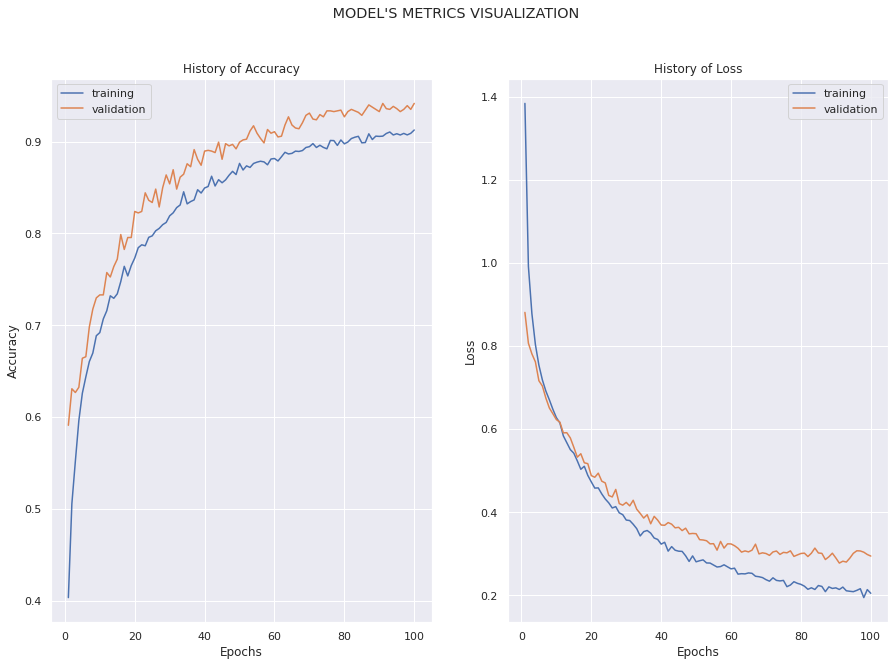

In [47]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [48]:
y_pred=model.predict_classes(x_test)
y_test=[np.argmax(x) for x in y_test]
y_pred_prb=model.predict_proba(x_test)

In [49]:
# def print_performance_metrics(y_test,y_pred):
#     """
#         parameters
#         ----------
#         y_test : actual label (must be in non-one hot encoded form)
#         y_pred_test : predicted labels (must be in non-one hot encoded form, common output of predict methods of classifers)

#         returns
#         -------
#         prints the accuracy, precision, recall, F1 score, ROC AUC score, Cohen Kappa Score, Matthews Corrcoef and classification report   
    
#     """
target=["B","M","N"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.937
Precision: 0.9376
Recall: 0.937
F1 Score: 0.9372
ROC AUC Score: 0.9754
Cohen Kappa Score: 0.883
		Classification Report:
               precision    recall  f1-score   support

           B       0.90      0.90      0.90       429
           M       0.90      0.94      0.92       375
           N       0.96      0.95      0.95      1370

    accuracy                           0.94      2174
   macro avg       0.92      0.93      0.92      2174
weighted avg       0.94      0.94      0.94      2174

